# Encontros 6 e 7: Pequeno Mundo

Entre as décadas de 50 e 80, [Stanley Milgram](https://en.wikipedia.org/wiki/Stanley_Milgram) e outros pesquisadores realizaram uma série de experimentos que ficaram conhecidos em conjunto como
[experimento do pequeno mundo](https://en.wikipedia.org/wiki/Small-world_experiment). Seus resultados sugerem que, na rede de relacionamentos da sociedade, o caminho entre quaisquer dois indivíduos é relativamente curto, ou seja, o comprimento médio dos caminhos do grafo é baixo.

Cerca de 40 anos depois, os alunos no sexto perído da Engenharia de Computação do Insper realizaram experimentos que sugerem a existência de uma estrutura análoga no serviço online de músicas *Spotify.* Foi constatado que, seguindo o sistema de *Artistas Relacionados*, é possível sair de um artista contemporâneo popular e chegar em um artista clássico consagrado usando de oito a dez passos.

Como podemos caracterizar essas *redes pequeno mundo*? Como podemos afirmar que um grafo é pequeno mundo e outro não?

In [1]:
# Módulos necessários.

from random import shuffle
from statistics import mean
from itertools import combinations

import pandas as pd
import seaborn as sns
import networkx as nx

import socnet as sn


# Parâmetros ajustáveis.

NUM_NODES = 16
MAX_NODES = 64

NUM_TIMES = 32

AVG_DEGREE = 8


# Configuração de visualização.

sn.node_size = 10

sn.edge_width = 1


# Função de conveniência para mostrar grafos.

def show_graph(g):
    sn.reset_node_colors(g)
    sn.reset_edge_colors(g)

    sn.show_graph(g)


# Função de conveniência para plotar agregados.

def plot(xlabel, xdata, ylabel, ydata):
    df = pd.DataFrame({xlabel: xdata, ylabel: ydata})

    sns.relplot(data=df, x=xlabel, y=ylabel, kind='line')

## Caminhos relativamente curtos

Primeiramente, precisamos evitar caracterizações baseadas em algum "número mágico" como [seis](https://en.wikipedia.org/wiki/Six_degrees_of_separation). A diferença entre os comprimentos médios obtidos pelo Milgram e os comprimentos médios obtidos do Spotify exigem uma caracterização mais genérica.

Informalmente, a definição de pequeno mundo já foi estabelecida: um grafo cujos caminhos são *relativamente curtos*. Nosso objetivo é formalizar o suficiente essa definição para poder usá-la em um teste de hipótese.

Um primeiro passso natural é tentar visualizar uma rede pequeno mundo para obter *insights* sobre a "cara" dela.

Nas lousinhas, as duplas Graicer/Tirta e Fred/Rapha apresentaram propostas baseadas em *árvore*. Uma árvore é uma *rede conexa sem circuitos*, ou seja, é um grafo com as seguintes propriedades:

* entre quaisquer dois nós, existe um caminho;
* esse caminho é o único entre esses nós.

O módulo *NetworkX* possui uma função pronta para gerar uma árvore aleatória com dado número de nós.

In [2]:
# Gera uma árvore aleatória.
g = nx.random_tree(NUM_NODES)

# Atribui posições aos nós.
sn.set_spring_positions(g)

# Mostra o grafo.
show_graph(g)

Os caminhos desse grafo são de fato relativamente curtos...

In [3]:
nx.average_shortest_path_length(g)

4.091666666666667

...mas há uma pequena "trapaça" envolvida: os caminhos são curtos *supondo esse dado número de nós*.

Vamos ver o que acontece com o comprimento médio conforme variamos esse número.

repetição 1
repetição 2
repetição 3
repetição 4
repetição 5
repetição 6
repetição 7
repetição 8
repetição 9
repetição 10
repetição 11
repetição 12
repetição 13
repetição 14
repetição 15
repetição 16
repetição 17
repetição 18
repetição 19
repetição 20
repetição 21
repetição 22
repetição 23
repetição 24
repetição 25
repetição 26
repetição 27
repetição 28
repetição 29
repetição 30
repetição 31
repetição 32


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



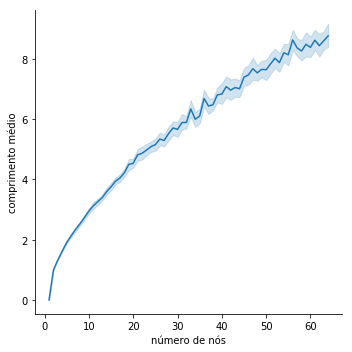

In [4]:
xdata = []
ydata = []

# Repete o experimento várias vezes.
for t in range(NUM_TIMES):

    # Para cada número de nós possível...
    for x in range(1, MAX_NODES + 1):

        # ...gera uma árvore aleatória...
        g = nx.random_tree(x)

        # ... e registra o par (número de nós X comprimento médio).
        xdata.append(x)
        ydata.append(nx.average_shortest_path_length(g))

    print('repetição {}'.format(t + 1))

# Plota resultado agregado dos experimentos.
plot('número de nós', xdata, 'comprimento médio', ydata)

Xi, o comprimento médio cresce quase linearmente em função do número de nós... ou seja, a estrutura de árvore não parece modelar um pequeno mundo em redes maiores.

As duplas Sabrina/Leo e Ale/Paulo pensaram em uma proposta alternativa: um anel de nós com "atalhos" adicionados especificamente para encurtar os caminhos. Esse tipo de aresta, que "atravessa" um circuito, é conhecido como *corda*.

A função abaixo constrói uma rede desse tipo, mas com uma restrição: além do número de nós, ela exige que você especifique qual é o *grau médio* que o grafo deve ter. O *grau* de um nó é o número de arestas que estão ligadas a ele, portanto, o grau médio é proporcional à *densidade* do grafo, ou seja, ao número total de arestas.

Por que estamos impondo essa restrição? Para evitar uma "segunda trapaça": queremos uma caracterização *estrutural* de pequeno mundo, que permita comparar grafos com *mesmo número de nós* e *mesma densidade*. Essa proposta de anel com cordas só pode ser considerada promissora se parar em pé sem o "migué" de ficarmos adicionando atalhos à vontade até os caminhos ficarem curtos o suficiente.

In [6]:
def chorded_ring(num_nodes, avg_degree):

    # Gera um grafo circular.
    g = nx.cycle_graph(num_nodes)

    # Prepara uma lista de pares de nós para sorteio.
    edges = [(n, m) for n, m in combinations(g.nodes, 2)]
    shuffle(edges)

    # Calcula limite de arestas a partir do grau médio.
    # Você consegue enxergar porque essa relação vale?
    max_edges = int((num_nodes * avg_degree) / 2 + 0.5)

    # Para cada par de nós sorteado...
    for n, m in edges:

        # ...se a aresta correspondente não existe...
        if not g.has_edge(n, m):

            # ...cria a aresta, ou seja, adiciona o "atalho"...
            g.add_edge(n, m)

            # ... e, se atingir o limite, para.
            if g.number_of_edges() == max_edges:
                break

    return g


# Gera um anel com cordas.
g = chorded_ring(NUM_NODES, AVG_DEGREE)

# Atribui posições aos nós.
sn.set_circle_positions(g)

# Mostra o grafo.
show_graph(g)

Os caminhos desse grafo são de fato relativamente curtos...

In [7]:
nx.average_shortest_path_length(g)

1.475

...então vamos verificar se a "trapaça" anterior não está se repetindo.

Vamos ver o que acontece com o comprimento médio conforme variamos o número de nós.

repetição 1
repetição 2
repetição 3
repetição 4
repetição 5
repetição 6
repetição 7
repetição 8
repetição 9
repetição 10
repetição 11
repetição 12
repetição 13
repetição 14
repetição 15
repetição 16
repetição 17
repetição 18
repetição 19
repetição 20
repetição 21
repetição 22
repetição 23
repetição 24
repetição 25
repetição 26
repetição 27
repetição 28
repetição 29
repetição 30
repetição 31
repetição 32


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



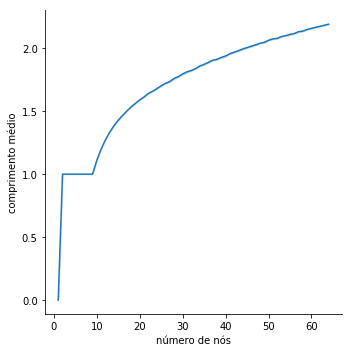

In [8]:
xdata = []
ydata = []

# Repete o experimento várias vezes.
for t in range(NUM_TIMES):

    # Para cada número de nós possível...
    for x in range(1, MAX_NODES + 1):

        # ...gera um anel com cordas...
        g = chorded_ring(x, AVG_DEGREE)

        # ... e registra o par (número de nós X comprimento médio).
        xdata.append(x)
        ydata.append(nx.average_shortest_path_length(g))

    print('repetição {}'.format(t + 1))

# Plota resultado agregado dos experimentos.
plot('número de nós', xdata, 'comprimento médio', ydata)

Opa, isso é promissor! Temos um comportamento quase logaritmico, ou seja, parece que o comprimento médio praticamente estabiliza a partir de um certo número de nós. Isso parece ser uma boa proposta de pequeno mundo! Mas...

## O teste do macaco

As duplas Elisa/Bruna e Isabella/Hugo repararam que esse tipo de comportamento logaritmico também parece ser verdade para um grafo *aleatório*. O que significa grafo aleatório? Imagine um grafo que começa vazio, sem nenhuma aresta, e aos poucos um macaco vai colocando arestas aleatoriamente.

Esse modelo de construção é conhecido como [Erdos-Renyi](https://en.wikipedia.org/wiki/Erd%C5%91s%E2%80%93R%C3%A9nyi_model) e sua formalização é simples: existe uma probabilidade $p$ tal que, para quaisquer dois nós $n$ e $m$, a probabilidade da aresta $\{n, m\}$ existir é $p$.

É fácil adaptar uma função pronta do *NetworkX* para gerar grafos Erdos-Renyi com dado número de nós e dado grau médio esperado.

In [9]:
def erdos_renyi_graph(num_nodes, avg_degree):
    if num_nodes == 1:
        return nx.empty_graph(num_nodes)

    # Calcula limite de arestas a partir do grau médio.
    # Você consegue enxergar porque essa relação vale?
    max_edges = int((num_nodes * avg_degree) / 2 + 0.5)

    # A partir desse limite de arestas, calculamos o p.
    p = max_edges / (num_nodes * (num_nodes - 1))

    # Agora podemos usar a função pronta, baseada em p.
    return nx.erdos_renyi_graph(num_nodes, p)


# Gera um grafo aleatório.
g = erdos_renyi_graph(NUM_NODES, AVG_DEGREE)

# Atribui posições aos nós.
sn.set_spring_positions(g)

# Mostra o grafo.
show_graph(g)

Novamente, vamos ver o que acontece com o comprimento médio conforme variamos o número de nós.

repetição 1
repetição 2
repetição 3
repetição 4
repetição 5
repetição 6
repetição 7
repetição 8
repetição 9
repetição 10
repetição 11
repetição 12
repetição 13
repetição 14
repetição 15
repetição 16
repetição 17
repetição 18
repetição 19
repetição 20
repetição 21
repetição 22
repetição 23
repetição 24
repetição 25
repetição 26
repetição 27
repetição 28
repetição 29
repetição 30
repetição 31
repetição 32


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



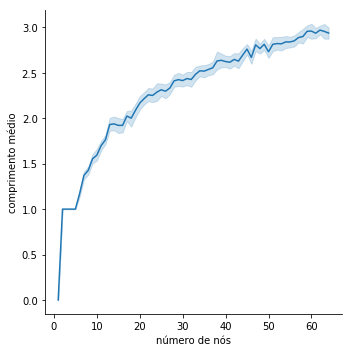

In [10]:
xdata = []
ydata = []

# Repete o experimento várias vezes.
for t in range(NUM_TIMES):

    # Para cada número de nós possível...
    for x in range(1, MAX_NODES + 1):

        # ...gera um grafo aleatório...
        g = erdos_renyi_graph(x, AVG_DEGREE)

        # ... e registra o par (número de nós X comprimento médio).
        xdata.append(x)
        lengths = []
        for n, m in combinations(g.nodes, 2):
            try:
                length = nx.shortest_path_length(g, n, m)
            except nx.NetworkXNoPath:
                length = 0
            lengths.append(length)
        ydata.append(mean(lengths) if lengths else 0)

    print('repetição {}'.format(t + 1))

# Plota resultado agregado dos experimentos.
plot('número de nós', xdata, 'comprimento médio', ydata)

#### Er... algo de errado não está certo... a proposta do anel com cordas antes parecia promissora, mas agora estamos vendo que ela é um pouco melhor mas não muito diferente do grafo do macaco! E, considerando os exemplos reais que conhecemos, o grafo do macaco definitivamente não é um pequeno mundo!

Na verdade, pequenos mundos são caracterizados por mais do que simplesmente a média dos caminhos.

## O coeficiente de transitividade *(clustering coefficient)*

Lembram da pequena demonstração feita em sala?

* A partir de Mozart, podemos ir para Chopin, Beethoven, Grieg, Bach, Puccini, Brahms, Dvorak, Debussy, Vivaldi...
* A partir de Chopin, podemos ir para Beethoven, Grieg, Debussy, Brahms, Dvorak, Mozart, Bach, Vivaldi...
* A partir de Beethoven, podemos ir para Grieg, Brahms, Debussy, Bach, Mozart, Dvorak, Vivaldi...

Aparentemente temos uma "panelinha", ou *clique* na terminologia de grafos: um conjunto de nós tal que todos estão conectados com todos. É essa presença de cliques que não vemos nem no anel com cordas e nem no grafo aleatório.

Um *verdadeiro* pequeno mundo possui, ao mesmo tempo, caminhos relativamente curtos e alta presença de cliques. Essa é a caracterização completa! Mas como quantificar isso?

Podemos observar que uma alta presença de cliques está diretamente relacionada ao fenômeno de *transitividade*, ou seja, dados três nós $n, m ,l$, temos que, se $n, m$ estão conectados e $m, l$ estão conectados, então há uma grande chance de $n, l$ estarem conectados.

O *coeficiente de transitividade* de um nó $n$ é

$$\mathcal{C}(n) = \frac{\textrm{quantidade de pares de vizinhos de }n\textrm{ que estão conectados entre si}}{\textrm{quantidade total de pares de vizinhos de }n}$$

e o coeficiente de transitividade de uma rede é a média dos coeficientes de transitividade de seus nós. Esse valor pode ser usado como métrica da presença de cliques em um grafo! Vejamos sua variação para o anel com cordas.

repetição 1
repetição 2
repetição 3
repetição 4
repetição 5
repetição 6
repetição 7
repetição 8
repetição 9
repetição 10
repetição 11
repetição 12
repetição 13
repetição 14
repetição 15
repetição 16
repetição 17
repetição 18
repetição 19
repetição 20
repetição 21
repetição 22
repetição 23
repetição 24
repetição 25
repetição 26
repetição 27
repetição 28
repetição 29
repetição 30
repetição 31
repetição 32


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



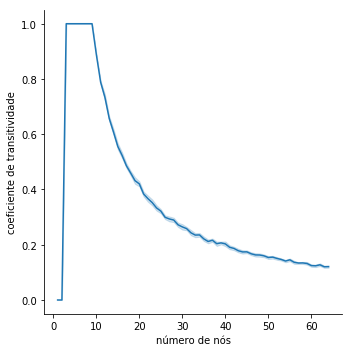

In [11]:
xdata = []
ydata = []

# Repete o experimento várias vezes.
for t in range(NUM_TIMES):

    # Para cada número de nós possível...
    for x in range(1, MAX_NODES + 1):

        # ...gera um anel com cordas...
        g = chorded_ring(x, AVG_DEGREE)

        # ... e registra o par (número de nós X coeficiente de transitividade).
        xdata.append(x)
        ydata.append(nx.average_clustering(g))

    print('repetição {}'.format(t + 1))

# Plota resultado agregado dos experimentos.
plot('número de nós', xdata, 'coeficiente de transitividade', ydata)

A presença de cliques *cai* conforme o número de nós cresce! Vejamos a variação para o grafo aleatório.

repetição 1
repetição 2
repetição 3
repetição 4
repetição 5
repetição 6
repetição 7
repetição 8
repetição 9
repetição 10
repetição 11
repetição 12
repetição 13
repetição 14
repetição 15
repetição 16
repetição 17
repetição 18
repetição 19
repetição 20
repetição 21
repetição 22
repetição 23
repetição 24
repetição 25
repetição 26
repetição 27
repetição 28
repetição 29
repetição 30
repetição 31
repetição 32


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



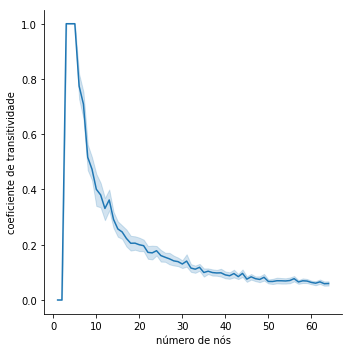

In [12]:
xdata = []
ydata = []

# Repete o experimento várias vezes.
for t in range(NUM_TIMES):

    # Para cada número de nós possível...
    for x in range(1, MAX_NODES + 1):

        # ...gera um grafo aleatório...
        g = erdos_renyi_graph(x, AVG_DEGREE)

        # ... e registra o par (número de nós x coeficiente de transitividade).
        xdata.append(x)
        ydata.append(nx.average_clustering(g))

    print('repetição {}'.format(t + 1))

# Plota resultado agregado dos experimentos.
plot('número de nós', xdata, 'coeficiente de transitividade', ydata)

Podemos confirmar que, infelizmente, o anel com cordas não está oferecendo muito de pequeno mundo além do que o macaco pode oferecer, pois ambos perdem cliques conforme crescem... Mas essa investigação nos deu informações valiosas!

## A necessidade de um benchmark

Podemos perceber, pelos resultados acima, que obter uma métrica não basta: precisamos também de uma *referência* para podermos interpretar o que o valor obtido significa. Fizemos isso no primeiro encontro, lembram? Sabíamos que a rede de citações era desigual por que tínhamos uma referência de igualdade: a *distribuição normal*.

Então qual seria nosso benchmark de "mundo-pequenez"? A dupla Isabella/Hugo fez uma sugestão interessante: usar grafos que são reconhecidamente pequeno mundo para deduzir um benchmark a partir deles. Seríamos a favor dessa sugestão se:

1. tivéssemos o acesso a um grande volume desses grafos e a confiança de que o reconhecimento de pequeno mundo foi preciso;
2. esta fosse uma disciplina voltada a *Machine Learning*. :)

Infelizmente, não podemos supor isso, então temos que procurar algo mais simples...

Note que o grafo aleatório é uma boa referência de *comprimento médio desejado* mas *coeficiente de transitividade indesejado*. O mínimo que se espera de uma rede pequeno mundo é que tenha um coeficiente de transitividade melhor que o do grafo aleatório.

Será que existe uma boa referência de *coeficiente de transitividade desejado* mas *comprimento médio indesejado*? Sim! Tudo o que precisamos fazer é um "anel de cliques". Observe a função abaixo.

In [13]:
def caveman_graph(num_nodes, avg_degree):
    if avg_degree % 2 != 0:
        raise ValueError('grau médio deve ser par')

    # Gera um grafo circular.
    g = nx.cycle_graph(num_nodes)

    # Calcula o limite de arestas que
    # cada nó dispara para cada lado.
    max_edges = avg_degree // 2

    # Prepara uma lista de nós para percorrer por índice.
    nodes = list(g.nodes)

    # Para cada nó...
    for i in range(len(nodes)):
        n = nodes[i]

        # ...e cada aresta a disparar...
        for shift in range(2, max_edges + 1):
            j = (i + shift) % len(nodes)
            m = nodes[j]

            # ...dispara a aresta.
            g.add_edge(n, m)

    return g


# Gera um anel de cliques.
g = caveman_graph(NUM_NODES, AVG_DEGREE)

# Atribui posições aos nós.
sn.set_circle_positions(g)

# Mostra o grafo.
show_graph(g)

Vejamos a variação do comprimento médio...

repetição 1
repetição 2
repetição 3
repetição 4
repetição 5
repetição 6
repetição 7
repetição 8
repetição 9
repetição 10
repetição 11
repetição 12
repetição 13
repetição 14
repetição 15
repetição 16
repetição 17
repetição 18
repetição 19
repetição 20
repetição 21
repetição 22
repetição 23
repetição 24
repetição 25
repetição 26
repetição 27
repetição 28
repetição 29
repetição 30
repetição 31
repetição 32


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



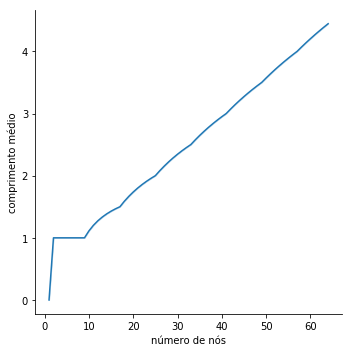

In [14]:
xdata = []
ydata = []

# Repete o experimento várias vezes.
for t in range(NUM_TIMES):

    # Para cada número de nós possível...
    for x in range(1, MAX_NODES + 1):

        # ...gera um anel de cliques...
        g = caveman_graph(x, AVG_DEGREE)

        # ... e registra o par (número de nós X comprimento médio).
        xdata.append(x)
        ydata.append(nx.average_shortest_path_length(g))

    print('repetição {}'.format(t + 1))

# Plota resultado agregado dos experimentos.
plot('número de nós', xdata, 'comprimento médio', ydata)

...e a variação do coeficiente de transitividade.

repetição 1
repetição 2
repetição 3
repetição 4
repetição 5
repetição 6
repetição 7
repetição 8
repetição 9
repetição 10
repetição 11
repetição 12
repetição 13
repetição 14
repetição 15
repetição 16
repetição 17
repetição 18
repetição 19
repetição 20
repetição 21
repetição 22
repetição 23
repetição 24
repetição 25
repetição 26
repetição 27
repetição 28
repetição 29
repetição 30
repetição 31
repetição 32


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



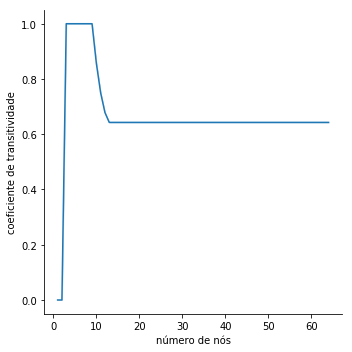

In [15]:
xdata = []
ydata = []

# Repete o experimento várias vezes.
for t in range(NUM_TIMES):

    # Para cada número de nós possível...
    for x in range(1, MAX_NODES + 1):

        # ...gera um anel de cliques...
        g = caveman_graph(x, AVG_DEGREE)

        # ... e registra o par (número de nós X coeficiente de transitividade).
        xdata.append(x)
        ydata.append(nx.average_clustering(g))

    print('repetição {}'.format(t + 1))

# Plota resultado agregado dos experimentos.
plot('número de nós', xdata, 'coeficiente de transitividade', ydata)

Conclusão: o mínimo que se espera de uma rede pequeno mundo é que tenha um comprimento médio menor que o do anel de cliques.

Entendeu todos os *grafos* e *gráficos* acima? Está na hora de redigir a hipótese.